In [1]:
import pandas as pd
import numpy as np

### getting companie and their reprisk

In [2]:
import wrds

In [85]:
conn = wrds.Connection(wrds_username='jongmok1031')

Loading library list...
Done


In [4]:
query = conn.raw_sql("""select ri.*, ci.primary_ISIN, ci.name
                        from reprisk.pm_rri_data ri
                        left join reprisk.pm_company_identifiers ci
                        on ri.reprisk_id = ci.reprisk_id
                        where ci.headquarter_country = 'United States of America' and ri.date > '2020-01-01' and ci.primary_isin is not null
                        """, date_cols=['date'])
US_companies = pd.DataFrame(data=query)

In [6]:
US_companies['primary_isin'].nunique()

4601

In [7]:
US_companies['name'].nunique()

4601

### getting tickers for the companies above

In [54]:
from time import sleep
import requests
import timeit

In [9]:
isins = list(US_companies['primary_isin'].unique())

In [24]:
def get_us_ticker_form_isin(isin):

    # https://www.openfigi.com/api
    #import requests

    url = 'https://api.openfigi.com/v1/mapping'
    headers = {'Content-Type':'text/json', 'X-OPENFIGI-APIKEY':'46a82b66-6569-4077-b14a-2aa771bb933f' }
    payload = '[{"idType":"ID_ISIN","idValue":"' + isin + '"}]'

    r = requests.post(url, headers=headers, data=payload)
    
    try:
        return r.json()[0].get('data')[0].get('ticker')
    except:
        return 'fail'

In [67]:
tickers = []
for i in range(len(isins)):
    if i%25 == 0 and i != 0:
        print("25 isins done " + str(len(isins) - i) + " to go")
    
    ticker = get_us_ticker_form_isin(isins[i])
    tickers.append(ticker)
    
    # API limit 25 per requests per 6 seconds
    sleep(6/23)

25 isins done 4576 to go
25 isins done 4551 to go
25 isins done 4526 to go
25 isins done 4501 to go
25 isins done 4476 to go
25 isins done 4451 to go
25 isins done 4426 to go
25 isins done 4401 to go
25 isins done 4376 to go
25 isins done 4351 to go
25 isins done 4326 to go
25 isins done 4301 to go
25 isins done 4276 to go
25 isins done 4251 to go
25 isins done 4226 to go
25 isins done 4201 to go
25 isins done 4176 to go
25 isins done 4151 to go
25 isins done 4126 to go
25 isins done 4101 to go
25 isins done 4076 to go
25 isins done 4051 to go
25 isins done 4026 to go
25 isins done 4001 to go
25 isins done 3976 to go
25 isins done 3951 to go
25 isins done 3926 to go
25 isins done 3901 to go
25 isins done 3876 to go
25 isins done 3851 to go
25 isins done 3826 to go
25 isins done 3801 to go
25 isins done 3776 to go
25 isins done 3751 to go
25 isins done 3726 to go
25 isins done 3701 to go
25 isins done 3676 to go
25 isins done 3651 to go
25 isins done 3626 to go
25 isins done 3601 to go


In [66]:
10*4800/60/60/25 # approx time to complete

0.5333333333333333

In [68]:
isins_ticker_us = pd.DataFrame([isins, tickers]).T
isins_ticker_us.columns = ['primary_isin', 'ticker_US']

In [70]:
#isins_ticker_us.to_csv('isins_ticker_us_4601.csv')

In [72]:
isins_ticker_us['ticker_US'].value_counts()

fail        124
REY           2
DUK           2
REAL          2
FLR           2
           ... 
RVM           1
PUMP          1
OOMA          1
1865332D      1
WSBF          1
Name: ticker_US, Length: 4455, dtype: int64

### joining tickers on reprisk data

In [73]:
US_companies = US_companies.merge(isins_ticker_us, how = 'inner', on = 'primary_isin')

In [83]:
US_companies.head(2)

,reprisk_id,date,current_rri,rri_trend,peak_rri,peak_rri_date,reprisk_rating,country_sector_average,environmental_percentage,social_percentage,governance_percentage,primary_isin,name,ticker_US
0,10010,2020-01-31,25.0,8.0,33.0,2019-03-08,A,22.0,0.60,0.30,0.10,US69327R1014,PDC Energy Inc (formerly Petroleum Development...,PDCE
1,10010,2020-02-29,26.0,1.0,33.0,2019-03-08,A,22.0,0.64,0.27,0.09,US69327R1014,PDC Energy Inc (formerly Petroleum Development...,PDCE


### getting monthly returns

In [76]:
import pandas_datareader as web

In [2]:
get_data_yahoo?

Object `get_data_yahoo` not found.


In [78]:
isins_ticker_us.shape[0]

4601

In [80]:
m_returns = pd.DataFrame(columns = ['date', 'monthly_return', 'ticker'])
for i in range(isins_ticker_us.shape[0]):
    ticker_US = isins_ticker_us.loc[i]['ticker_US']
    try:
        returns = web.get_data_yahoo(ticker_US,
                            start = "2006-12-29",
                            end = "2020-12-31") # dates of reprisk data
        monthly_returns_t = returns['Adj Close'].resample('M').ffill().pct_change()
        monthly_returns_t = pd.DataFrame(monthly_returns_t[1:]).reset_index()
        monthly_returns_t['ticker'] = ticker_US
        monthly_returns_t.columns = ['date', 'monthly_return', 'ticker']
    except:
        monthly_returns_t['ticker'] = ticker_US
        monthly_returns_t['monthly_return'] = 'fail'
    
    m_returns = pd.concat([m_returns,monthly_returns_t])
    if i%20 == 0 and i != 0:
        print('20 requests, ' + str(isins_ticker_us.shape[0]-i) + ' left' )

20 requests, 4581 left
20 requests, 4561 left
20 requests, 4541 left
20 requests, 4521 left
20 requests, 4501 left
20 requests, 4481 left
20 requests, 4461 left
20 requests, 4441 left
20 requests, 4421 left
20 requests, 4401 left
20 requests, 4381 left
20 requests, 4361 left
20 requests, 4341 left
20 requests, 4321 left
20 requests, 4301 left
20 requests, 4281 left
20 requests, 4261 left
20 requests, 4241 left
20 requests, 4221 left
20 requests, 4201 left
20 requests, 4181 left
20 requests, 4161 left
20 requests, 4141 left
20 requests, 4121 left
20 requests, 4101 left
20 requests, 4081 left
20 requests, 4061 left
20 requests, 4041 left
20 requests, 4021 left
20 requests, 4001 left
20 requests, 3981 left
20 requests, 3961 left
20 requests, 3941 left
20 requests, 3921 left
20 requests, 3901 left
20 requests, 3881 left
20 requests, 3861 left
20 requests, 3841 left
20 requests, 3821 left
20 requests, 3801 left
20 requests, 3781 left
20 requests, 3761 left
20 requests, 3741 left
20 requests

In [82]:
#m_returns.to_csv('m_returns_4601.csv')

## joining returns on reprisk data

In [89]:
query = conn.raw_sql("""select ri.*, ci.primary_ISIN, ci.name
                        from reprisk.pm_rri_data ri
                        left join reprisk.pm_company_identifiers ci
                        on ri.reprisk_id = ci.reprisk_id
                        where ci.headquarter_country = 'United States of America' and ci.primary_isin is not null
                        """, date_cols=['date'])
repriskdata = pd.DataFrame(data=query)

In [91]:
repriskdata = repriskdata.merge(isins_ticker_us, how = 'inner', on = 'primary_isin')

In [96]:
m_returns.columns = ['date', 'monthly_return', 'ticker_US']

In [99]:
repriskdata = repriskdata.merge(m_returns, how = 'left', on = ['ticker_US', 'date'])

In [104]:
repriskdata = repriskdata[repriskdata['ticker_US'] != 'fail']

In [106]:
repriskdata = repriskdata[repriskdata['monthly_return'] != 'fail']

In [108]:
repriskdata['primary_isin'].nunique()

2665

In [114]:
from dateutil.relativedelta import relativedelta

In [131]:
import matplotlib.pyplot as plt

In [140]:
n_companies = []
months = []
for i in range(167):
    months.append(i)
    n_companies.append(repriskdata[repriskdata['date'] == repriskdata['date'][0] 
                                   + relativedelta(months=i)]['monthly_return'].notna().sum())

In [143]:
plt.plot?

Text(0.5, 0, 'time in months from start 2007 to end 2020')

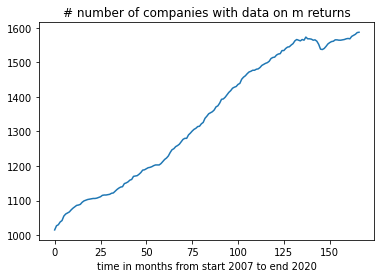

In [146]:
plt.plot(months, n_companies)
plt.title('# number of companies with data on m returns')
plt.xlabel('time in months from start 2007 to end 2020')

In [155]:
# these ticker might be wrong, should better delete them
counter = 0
bad_tickers = []
for i in list(repriskdata['ticker_US'].unique()):
    if i.find(' ') > 0:
        bad_tickers.append(i)
        counter += 1

In [160]:
#repriskdata.to_csv('repriskdata_2400_us_comp_returns.csv', index = False)

In [ ]:
52*4300/40/60

### debug

In [51]:
isin = 'US35803QAA58'
url = 'https://api.openfigi.com/v1/mapping'
headers = {'Content-Type':'text/json', 'X-OPENFIGI-APIKEY':'46a82b66-6569-4077-b14a-2aa771bb933f' }
payload = '[{"idType":"ID_ISIN","idValue":"' + isin + '"}]'

r = requests.post(url, headers=headers, data=payload)
    
r.json()

[{'data': [{'figi': 'BBG001DQ62T3',
    'name': 'FRESENIUS MED CARE US',
    'ticker': 'FMEGR 5.75 02/15/21 144A',
    'exchCode': 'TRACE',
    'compositeFIGI': None,
    'uniqueID': None,
    'securityType': 'PRIV PLACEMENT',
    'marketSector': 'Corp',
    'shareClassFIGI': None,
    'uniqueIDFutOpt': None,
    'securityType2': 'Corp',
    'securityDescription': 'FMEGR 5 3/4 02/15/21'}]}]

In [ ]:
r.json()[0].get('data')[0].get('ticker')

In [47]:
US_companies[US_companies['primary_isin'] == 'US12513GAA76'].head(1)

,reprisk_id,date,current_rri,rri_trend,peak_rri,peak_rri_date,reprisk_rating,country_sector_average,environmental_percentage,social_percentage,governance_percentage,primary_isin,name
360,101758,2020-01-31,0.0,-2.0,17.0,2019-01-15,AA,22.0,0.0,0.0,0.0,US12513GAA76,CDW LLC


In [50]:
isins[36]

'US35803QAA58'

In [49]:
tickers[36]

'FMEGR 5.75 02/15/21 144A'